#**CREDIT RISK ANALYTICS**


##**Problem Description**


The objective of the credit risk analysis is to assess the borrowers' creditworthiness by quantifying the risk of loss to which the lender is exposed. The probability of default, loss due to default, and exposure to default are the three measures that lenders use to measure credit risk.

This is the data set of mortgage observations for 50,000 residential U.S. mortgage borrowers over 60 periods, 600,000 records in total. The data set is a randomized selection of mortgage-loan-level data collected from the portfolios underlying U.S. residential mortgage-backed securities (RMBS) securitization portfolios and provided by International Financial Research (www.internationalfinancialresearch.org).

We have applied SVM, Random Forest, KNN, Logistic Regression Classfication models to determine whether the borrower is able pay their loan(0) or not(1) at the end of the maturity period. 

##Exploratory Data Analysis(EDA)

Key variables include:

*  id: Borrower ID
*  time: Time stamp of observation
* orig_time: Time stamp for origination
* first_time: Time stamp for first observation
* mat_time: Time stamp for maturity
* balance_time: Outstanding balance at observation time
* LTV_time: Loan-to-value ratio at observation time, in %
* interest_rate_time: Interest rate at observation time, in %
* hpi_time: House price index at observation time, base year = 100
* gdp_time: Gross domestic product (GDP) growth at observation time, in %
* uer_time: Unemployment rate at observation time, in 
* REtype_CO_orig_time: Real estate type condominium = 1, otherwise = 0
* REtype_PU_orig_time: Real estate type planned urban development = 1, otherwise = 0
* REtype_SF_orig_time: Single-family home = 1, otherwise = 0
* investor_orig_time: Investor borrower = 1, otherwise = 0
* balance_orig_time: Outstanding balance at origination time
* FICO_orig_time: FICO score at origination time, in %
* LTV_orig_time: Loan-to-value ratio at origination time, in %
* Interest_Rate_orig_time: Interest rate at origination time, in %
* hpi_orig_time: House price index at origination time, base year = 100
* default_time: Default observation at observation time
* payoff_time: Payoff observation at observation time
* status_time: Default (1), payoff (2), and nondefault/nonpayoff (0) observation at observation time



**Maturity Time Period**


In this dataset there are two variables -
time: Time stamp of observation and
orig_time: Time stamp for origination
 
Based on these columns we have derived a column maturity_time_period_days which is difference between these two varibales. By adding this column we can know in how many days the loan has been paid or how many days are there for the loan to reach the maturity.



**First day of observation during Maturity Time Period**


The variable orig_time has values of when the obervation of the loan started. So, we added a column name start_day_observation. This new column contains the subtraction of orig_time and first_time. This new column has the number of day on which the loan obeservation started during the Maturity Time Period (maturity_time_period_days).


### Import libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing dataset

In [125]:
dataset = pd.read_csv('/content/drive/My Drive/ML_Project/Credit_Risk_Analytics/Data/MORTAGAGE_DATA.csv', low_memory=False)

In [126]:
dataset.head()

id  maturity_time_period_days  ...  hpi_orig_time  default_time
0   1                        120  ...          87.03             2
1   1                        120  ...          87.03             2
2   1                        120  ...          87.03             2
3   1                        120  ...          87.03             2
4   1                        120  ...          87.03             2

[5 rows x 19 columns]

**Now we are taking the first value of start_day_observation from each group of customers**

The dataset has 600,000 records/observation of 50,000 customers. So, in order to obatin a single record for an individual customer we are performing Group By based on id of Customer. So, for this start_day_observation variable we have taken the first value in each group of the customer.
The variable start_day_observation contains that day at which the obersvation of Mortagage started from the total maturity_time_period_days.

In [127]:
start_day = pd.DataFrame(dataset[['id','start_day_observation']])
start_day.head()

id  start_day_observation
0   1                     32
1   1                     33
2   1                     34
3   1                     35
4   1                     36

In [128]:
start_day = start_day.groupby(by='id').first()
start_day.head()

start_day_observation
id                       
1                      32
2                       7
3                      31
4                      27
5                       7

**Now we are calculating the Percent Change of current balance between the first obeseration and last obeservation**

For the variable balance_time we have different amount varying from 0 to 8,70,1859 dollars. So, in order to efficiently analyze our data we are calculating the percentage difference and standardize the data in a scale. The percentage change is between the beginning balance and ending balance.


In [129]:
balance = pd.DataFrame(dataset[['id','balance_time']])
balance.head()

id  balance_time
0   1      41303.42
1   1      41061.95
2   1      40804.42
3   1      40483.89
4   1      40367.06

In [130]:
def pct_change(balance):
    balance.reset_index()
    balance['new_balance'] = 100 * ((balance.iloc[0].balance_time - balance.iloc[-1].balance_time) / balance.iloc[0].balance_time)
    return balance

balance_percent = balance.groupby('id').apply(pct_change)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [131]:
balance_percent = balance_percent.groupby(by='id').first()
balance_percent.head()

balance_time  new_balance
id                           
1       41303.42    29.576752
2      105826.38     0.162162
3       44866.18     1.086743
4       61031.10    13.672947
5       52295.07     0.371660

In [132]:
balance_percent = balance_percent.drop(['balance_time'], axis = 1)
balance_percent.head()

new_balance
id             
1     29.576752
2      0.162162
3      1.086743
4     13.672947
5      0.371660

In [133]:
balance_percent = balance_percent.rename(columns={"new_balance": "balance_time"})

In [134]:
balance_percent.head()

balance_time
id              
1      29.576752
2       0.162162
3       1.086743
4      13.672947
5       0.371660

The default_time column has the status of each records whether the mortgage's status of default is (0) Paid, (1) Not Paid, (2) Pending.
We have taken the last value for each group of customers in the default_time column. 

In [135]:
status= pd.DataFrame(dataset[['id','default_time']])
status= status.groupby(by='id').last()
status.head()

default_time
id              
1              1
2              0
3              0
4              2
5              0

In [136]:
dataset = dataset.groupby('id').mean()
dataset.head()

maturity_time_period_days  ...  default_time
id                             ...              
1                       120.0  ...      1.958333
2                       120.0  ...      1.000000
3                       120.0  ...      1.600000
4                       121.0  ...      2.000000
5                       120.0  ...      1.333333

[5 rows x 18 columns]

In [137]:
dataset['default_time']= status['default_time']
dataset['balance_time']= balance_percent['balance_time']
dataset['start_day_observation']= start_day['start_day_observation']

In [138]:
dataset.head()

maturity_time_period_days  ...  default_time
id                             ...              
1                       120.0  ...             1
2                       120.0  ...             0
3                       120.0  ...             0
4                       121.0  ...             2
5                       120.0  ...             0

[5 rows x 18 columns]

### Taking care of missing data

In [139]:
# Count total NaN in a DataFrame 
print("Count total NaN in a DataFrame : \n", 
       dataset.isnull().sum().sum()) 


Count total NaN in a DataFrame : 
 9


In [140]:
print(dataset.isnull().sum())

maturity_time_period_days    0
start_day_observation        0
balance_time                 9
LTV_time                     0
interest_rate_time           0
hpi_time                     0
gdp_time                     0
uer_time                     0
REtype_CO_orig_time          0
REtype_PU_orig_time          0
REtype_SF_orig_time          0
investor_orig_time           0
balance_orig_time            0
FICO_orig_time               0
LTV_orig_time                0
Interest_Rate_orig_time      0
hpi_orig_time                0
default_time                 0
dtype: int64


Here, we have taken the records with non null values.

In [141]:
# creating bool series True for NaN values
dataset1 = pd.notnull(dataset["balance_time"])
 
# filtering data
dataset = dataset[dataset1]

We have to remove records which are still in process or pending. In the last column default_time we are removig the records which have the (2) in their default_time column.

In [142]:
dataset = dataset[dataset.default_time != 2]

In [151]:
dataset

maturity_time_period_days  ...  default_time
id                                ...              
1                          120.0  ...             1
2                          120.0  ...             0
3                          120.0  ...             0
5                          120.0  ...             0
6                          120.0  ...             1
...                          ...  ...           ...
49967                      120.0  ...             0
49970                      120.0  ...             0
49972                      120.0  ...             1
49983                      120.0  ...             0
49984                      120.0  ...             0

[41735 rows x 18 columns]

### Saving the Preprocessed Data in Excel

In [152]:
dataset.to_csv('/content/drive/My Drive/ML_Project/Credit_Risk_Analytics/Data/New_Mortgage.csv')

##**Data Visulization**

First, we will visualize the distribution of the primary dependent variable, which is the default_time.

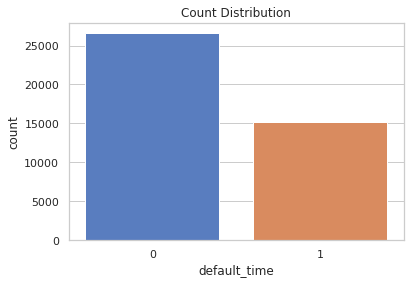

In [145]:
sns.set(style="whitegrid")
sns.countplot(x = dataset["default_time"], palette="muted")
plt.title("Count Distribution")
plt.show()

As we can see, the majority of the customers has (0) status which means that customers are able payoff their mortagage at the end of the maturity period.

Now we will plot a seaborn pairplot to observe the distribution of each variable on other.

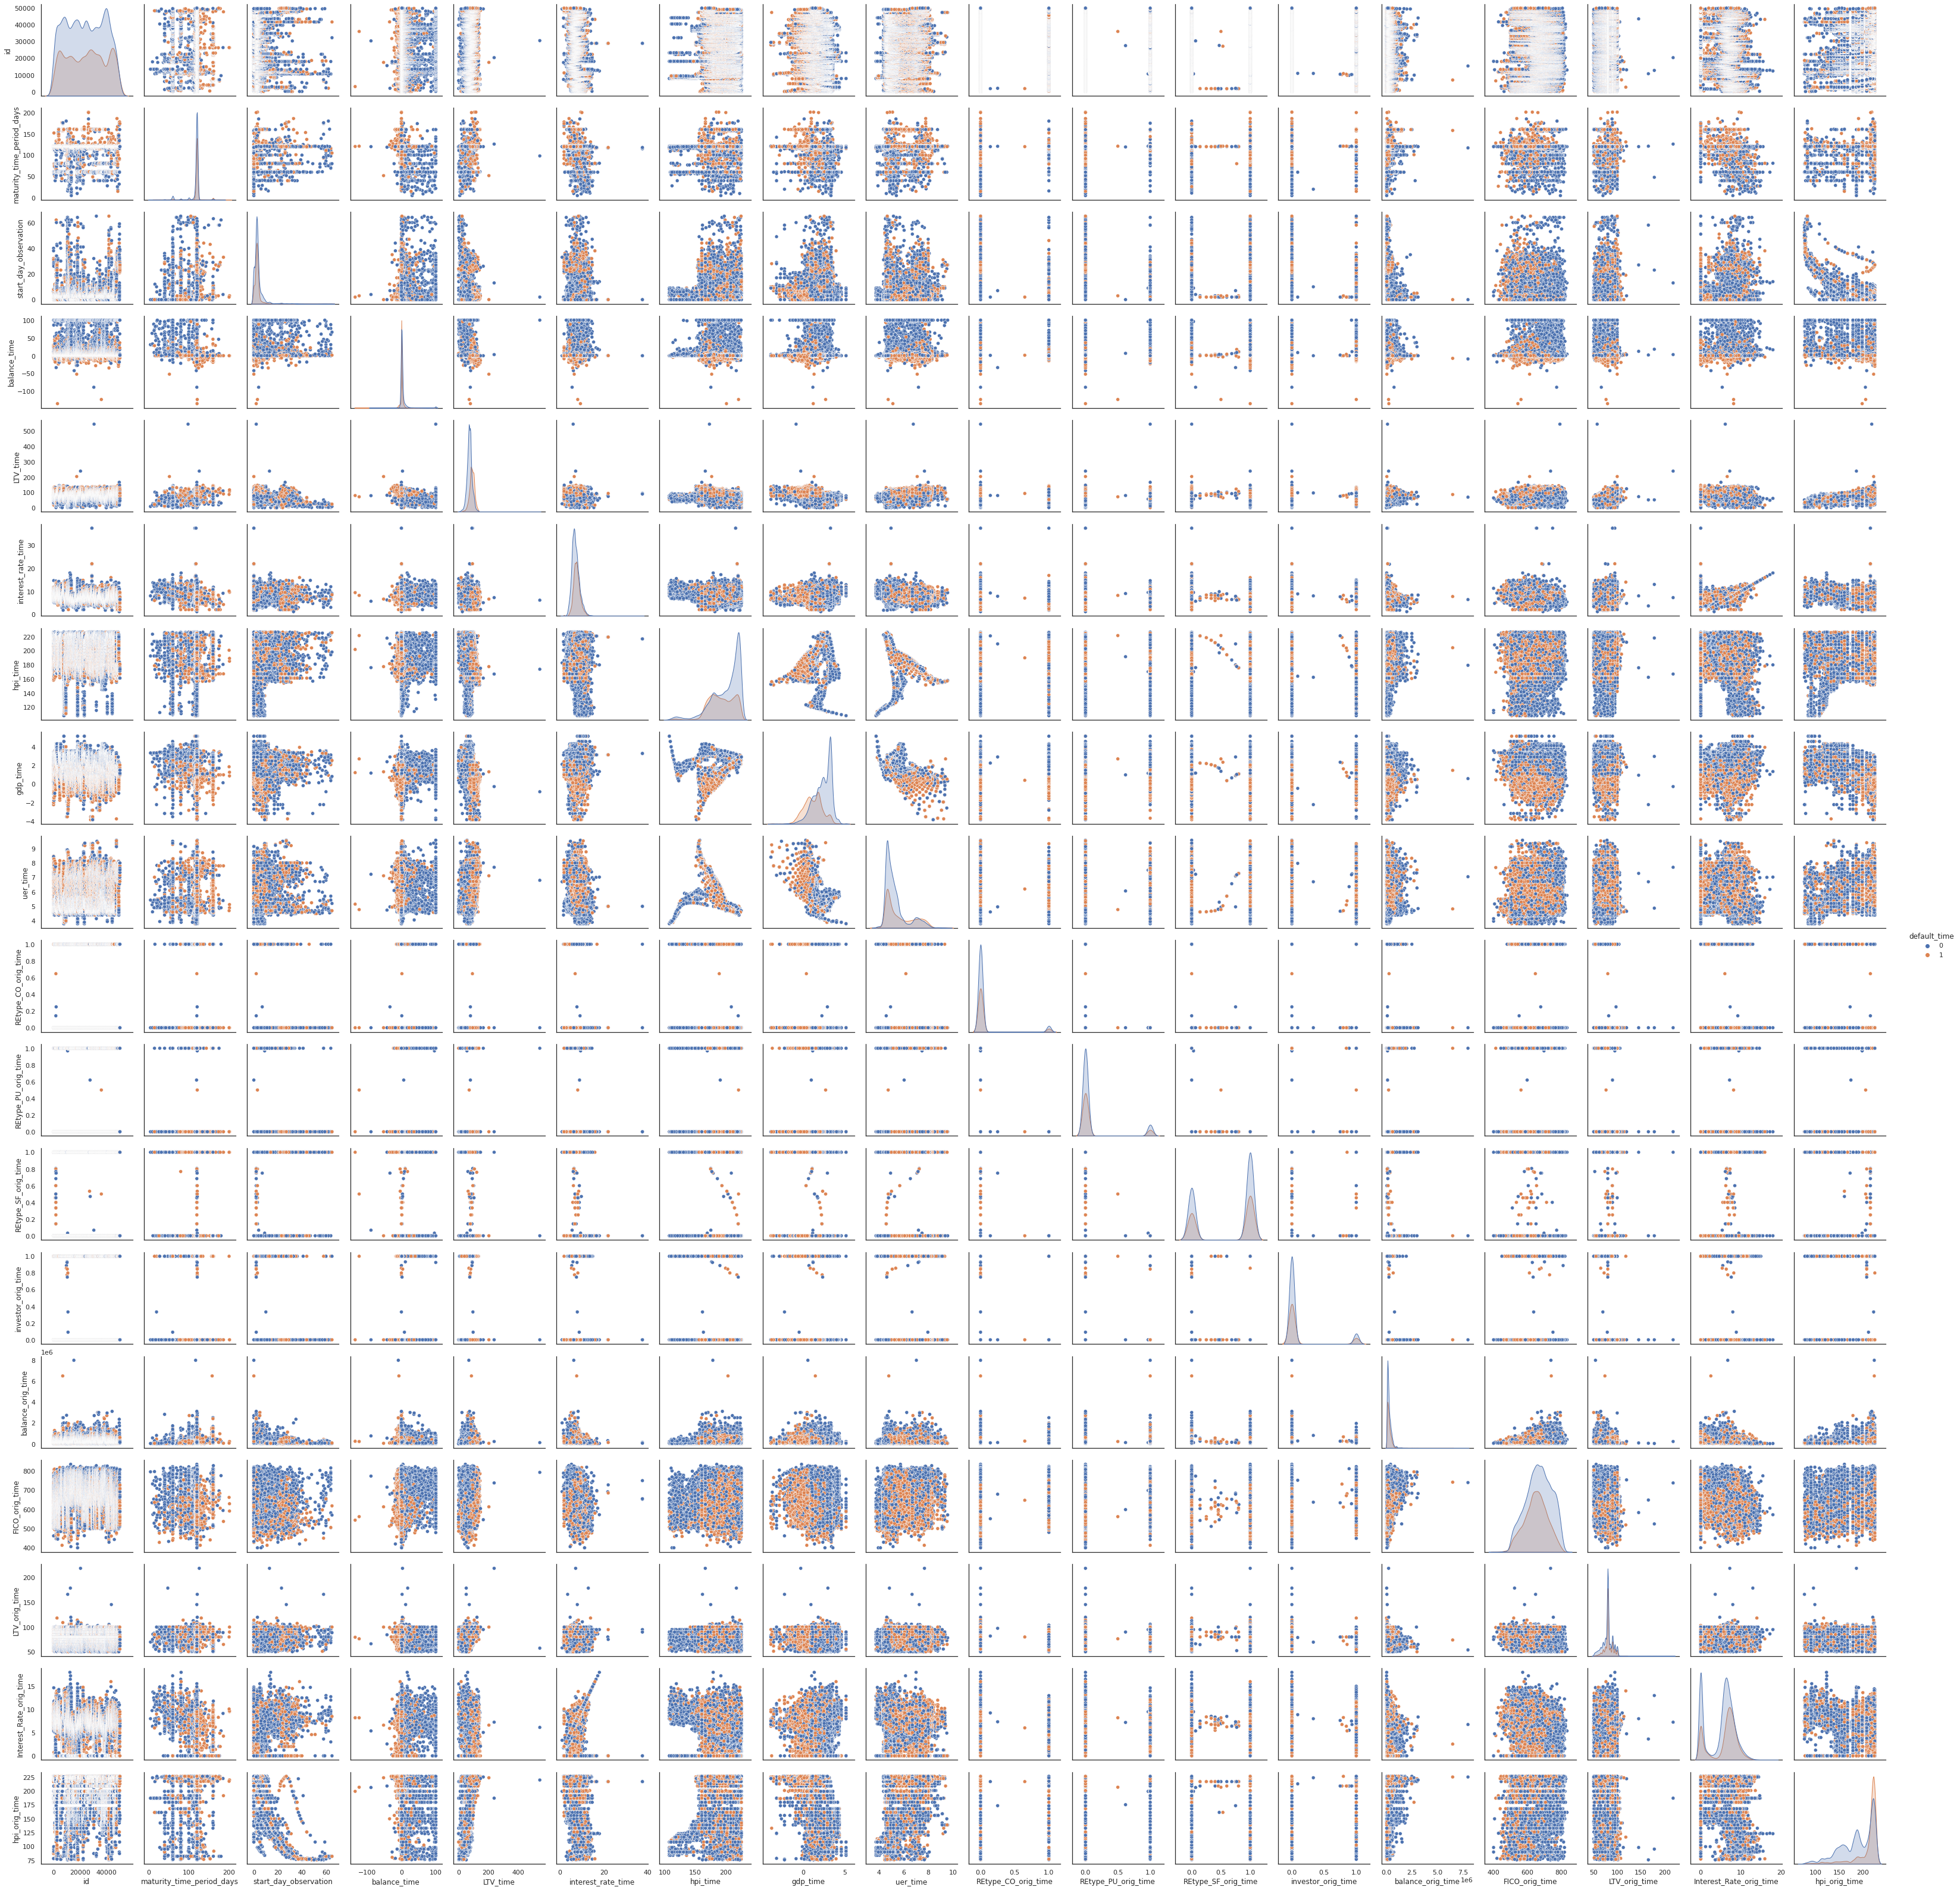

In [ ]:
sns.pairplot(dat, hue="default_time")

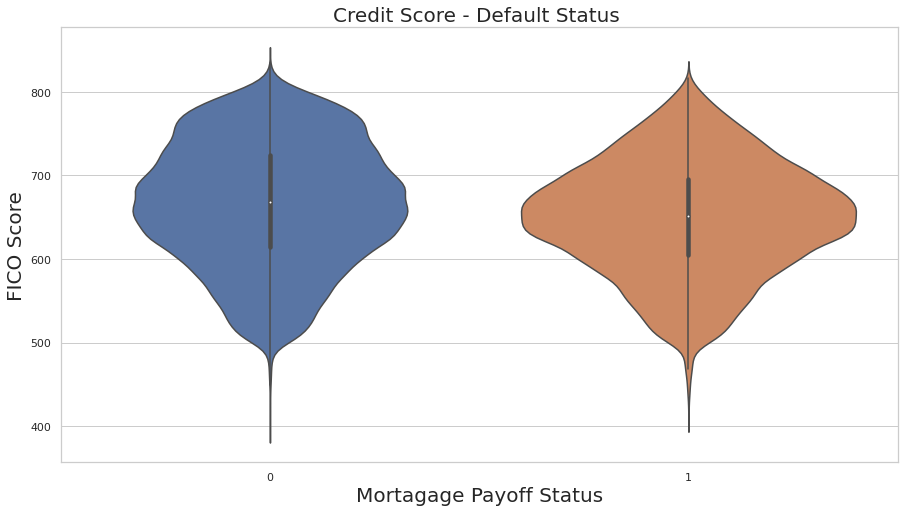

In [146]:
fig = plt.figure(figsize=(15,8))
sns.violinplot(x = "default_time", y="FICO_orig_time",data=dataset)
plt.title("Credit Score - Default Status ", fontsize=20)
plt.xlabel("Mortagage Payoff Status", fontsize=20)
plt.ylabel("FICO Score", fontsize=20);

Text(0.5, 1.0, 'Distribution of Interest Rate')

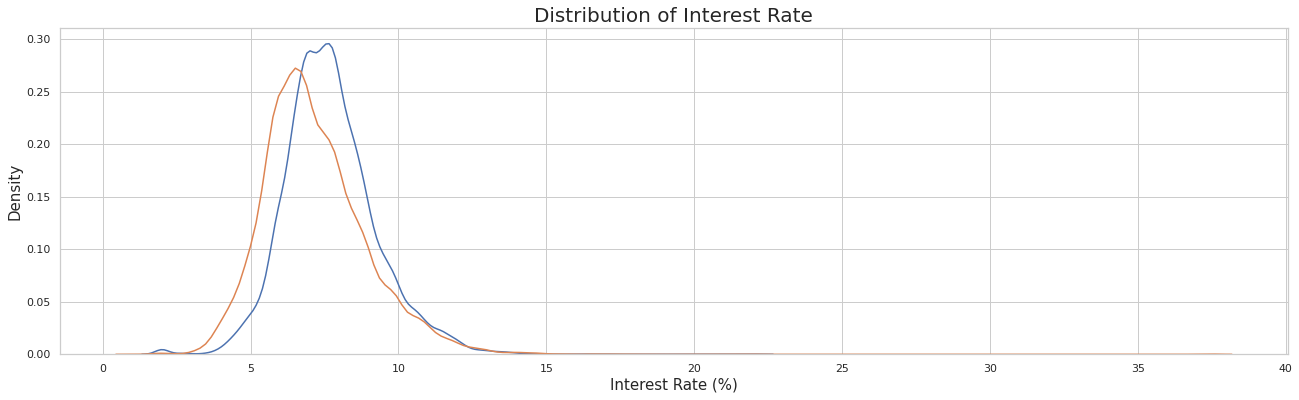

In [147]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(dataset.loc[dataset['default_time'] == 1, 'interest_rate_time'], label = 'target = 1')
sns.kdeplot(dataset.loc[dataset['default_time'] == 0, 'interest_rate_time'], label = 'target = 0');
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20)

Text(0.5, 1.0, 'Distribution of Unemployment Rate')

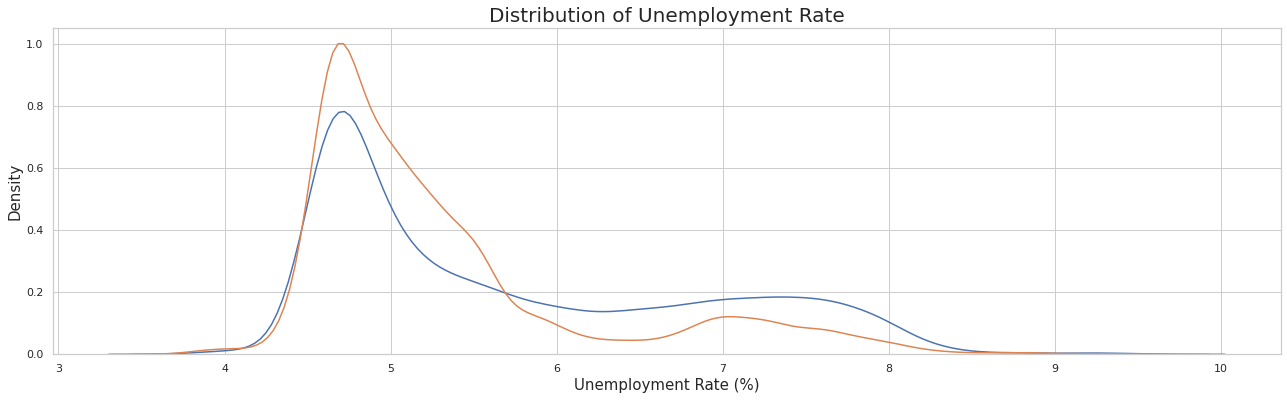

In [148]:
fig = plt.figure(figsize=(22,6))
sns.kdeplot(dataset.loc[dataset['default_time'] == 1, 'uer_time'], label = 'target = 1')
sns.kdeplot(dataset.loc[dataset['default_time'] == 0, 'uer_time'], label = 'target = 0');
plt.xlabel('Unemployment Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Unemployment Rate',fontsize=20)

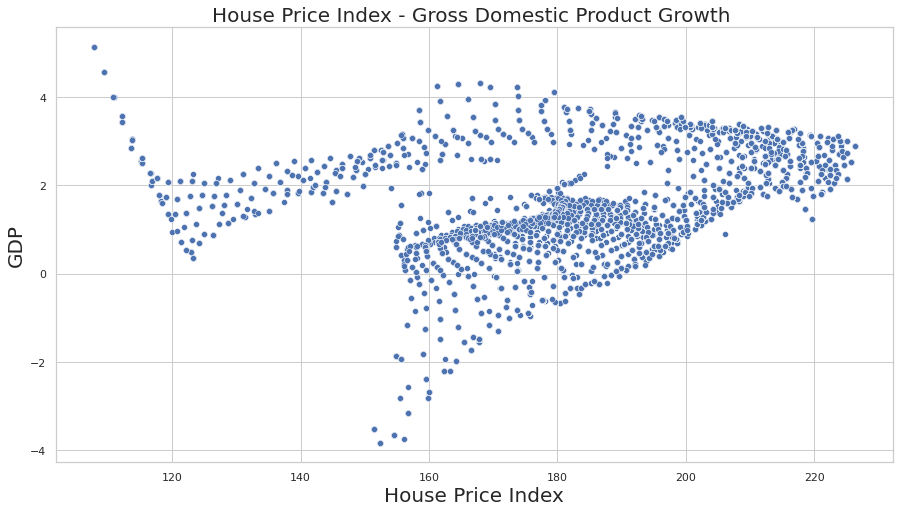

In [149]:
fig = plt.figure(figsize=(15,8))
sns.scatterplot(x = "hpi_time", y = "gdp_time",data=dataset)
plt.title("House Price Index - Gross Domestic Product Growth ", fontsize=20)
plt.xlabel("House Price Index", fontsize=20)
plt.ylabel("GDP", fontsize=20);

##**Model Buliding**

### Importing the updated dataset

In [184]:
dat = pd.read_csv('/content/drive/My Drive/ML_Project/Credit_Risk_Analytics/Data/New_Mortgage.csv', low_memory=False)
dat.head()

id  maturity_time_period_days  ...  hpi_orig_time  default_time
0   1                      120.0  ...          87.03             1
1   2                      120.0  ...         186.91             0
2   3                      120.0  ...          89.58             0
3   5                      120.0  ...         186.91             0
4   6                      120.0  ...         191.42             1

[5 rows x 19 columns]

### Splitting the dataset


In [186]:
X = dat.iloc[:, :-1]
Y = dat.iloc[:,-1]

### Correlation Matrix

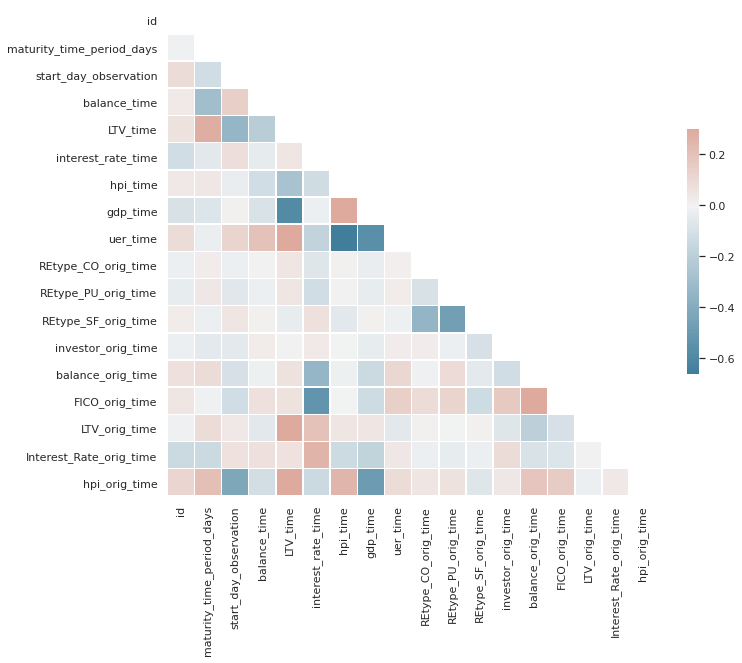

In [187]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = X.corr(method="pearson")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###Dropping the columns

In [188]:
X = X.drop(['id','hpi_orig_time','LTV_time'], axis = 1)

In [157]:
X = X.drop(['uer_time'], axis = 1)

### Splitting the dataset into the Training set and Test set




In [189]:
X = dat.iloc[:, :-1].values
Y = dat.iloc[:,-1].values

In [190]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 12)

### Feature Scaling

In [191]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)

### Over Sampling using SMOTE

SMOTE is a method of oversampling which produces synthetic samples from the minority class. It is used to achieve a synthetically class-balanced or almost class-balanced training set, which is then used to train the classifier.

We will use SMOTE to upsample our dependent variables.

In [208]:
from imblearn.over_sampling import SMOTE
sm = SMOTE("minority")
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [209]:
from collections import Counter
counter = Counter(y_train_res)
print(counter)

Counter({0: 21259, 1: 21259})


##**SVM**

### Training the SVM model on the Training set

In [210]:
from sklearn.svm import SVC
classifier = SVC(gamma='auto',kernel = 'rbf',C=2)
classifier.fit(x_train_res, y_train_res)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

### Predicting the Train set results

In [211]:
y_pred_train = classifier.predict(x_train_res)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train_res.reshape(len(y_train_res),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 1]
 [0 1]
 [1 1]]


In [212]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train_res, y_pred_train)
print(cm)
accuracy_score(y_train_res, y_pred_train)

[[16916  4343]
 [ 3537 17722]]


0.8146667293852016

### Predicting the Test set results

In [213]:
y_pred_test = classifier.predict(X_test)
print(np.concatenate((y_pred_test.reshape(len(y_pred_test),1), Y_test.reshape(len(Y_test),1)),1))

[[1 0]
 [1 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [214]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, y_pred_test)
print(cm)
accuracy_score(Y_test, y_pred_test)

[[4138 1184]
 [ 616 2409]]


0.784353659997604

### Precision Recall Curve

In [215]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report

print ('Recall:', recall_score(Y_test, y_pred_test))
print ('Precision:', precision_score(Y_test, y_pred_test))


Recall: 0.7963636363636364
Precision: 0.67047035903145


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.77')

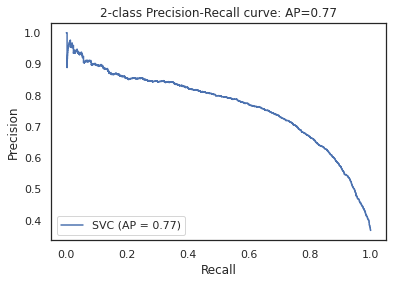

In [216]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

y_score = classifier.decision_function(X_test)

average_precision = average_precision_score(Y_test, y_score)

disp = plot_precision_recall_curve(classifier, X_test, Y_test)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

##**Random Forest**

### Training the Random Forest Classification model on the Training set

In [217]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 200, min_samples_leaf=45,oob_score=True)
classifier.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=45, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

### Predicting the Test set results

In [218]:
y_pred_test = classifier.predict(X_test)
print(np.concatenate((y_pred_test.reshape(len(y_pred_test),1), Y_test.reshape(len(Y_test),1)),1))

[[1 0]
 [1 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [219]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, y_pred_test)
print(cm)
accuracy_score(Y_test, y_pred_test)

[[4327  995]
 [ 717 2308]]


0.7948963699532766

### Predicting the Train set results

In [220]:
y_pred_train = classifier.predict(x_train_res)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train_res.reshape(len(y_train_res),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [1 1]]


In [221]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train_res, y_pred_train)
print(cm)
accuracy_score(y_train_res, y_pred_train)

[[17596  3663]
 [ 3974 17285]]


0.8203819558775107

### Precision Recall

In [222]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report

print ('Recall:', recall_score(Y_test, y_pred_test))
print ('Precision:', precision_score(Y_test, y_pred_test))

Recall: 0.7629752066115703
Precision: 0.6987587042082954


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.79')

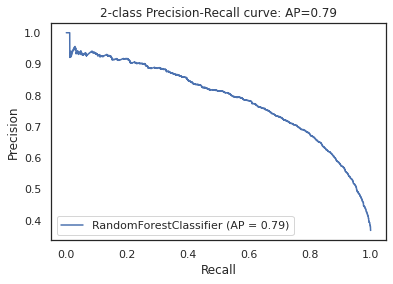

In [223]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

y_score = classifier.predict_proba(X_test)[:,-1]

average_precision = average_precision_score(Y_test, y_score)

disp = plot_precision_recall_curve(classifier, X_test, Y_test)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

##Logistic Regression

### Training the Logistic Regression model on the Training set

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predicting the Test set results

In [ ]:
y_pred_test = classifier.predict(X_test)
print(np.concatenate((y_pred_test.reshape(len(y_pred_test),1), Y_test.reshape(len(Y_test),1)),1))

[[1 0]
 [1 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, y_pred_test)
print(cm)
accuracy_score(Y_test, y_pred_test)

[[4549  773]
 [1214 1811]]


0.7619504013417995

### Predicting the Train set results

In [ ]:
y_pred_train = classifier.predict(x_train_res)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train_res.reshape(len(y_train_res),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [1 1]
 [1 1]
 [1 1]]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train_res, y_pred_train)
print(cm)
accuracy_score(y_train_res, y_pred_train)

[[18318  2941]
 [ 8544 12715]]


0.7298791100239899

##KNN

### Training the K-NN model on the Training set

In [177]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 15, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

### Predicting the Test set results

In [178]:
y_pred_test = classifier.predict(X_test)
print(np.concatenate((y_pred_test.reshape(len(y_pred_test),1), Y_test.reshape(len(Y_test),1)),1))

[[1 0]
 [1 0]
 [1 1]
 ...
 [0 0]
 [0 0]
 [0 0]]


In [179]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(Y_test, y_pred_test)
print(cm)
accuracy_score(Y_test, y_pred_test)

[[4462  860]
 [ 996 2029]]


0.777644662753085

### Predicting the Train set results

In [180]:
y_pred_train = classifier.predict(x_train_res)
print(np.concatenate((y_pred_train.reshape(len(y_pred_train),1), y_train_res.reshape(len(y_train_res),1)),1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [1 1]
 [0 1]
 [0 1]]


In [181]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_train_res, y_pred_train)
print(cm)
accuracy_score(y_train_res, y_pred_train)

[[18396  2863]
 [ 6113 15146]]


0.7888894115433464

###Precision Recall

In [182]:
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report

print ('Recall:', recall_score(Y_test, y_pred_test))
print ('Precision:', precision_score(Y_test, y_pred_test))

Recall: 0.6707438016528926
Precision: 0.702319141571478


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.73')

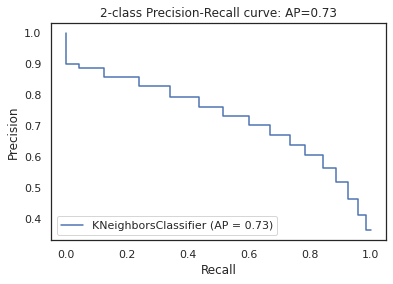

In [183]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

y_score = classifier.predict_proba(X_test)[:, -1]

average_precision = average_precision_score(Y_test, y_score)

disp = plot_precision_recall_curve(classifier, X_test, Y_test)

disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Conclusion

After analyzing all the different learning rates and methods we used, the Accuracy that we got was 79% using Random Forest Classifier. The average precision score we received is 0.79. 



#Future Scope

We will do more hyperparameter tuning to increase our accuracy results.